*UE Learning from User-generated Data, CP MMS, JKU Linz 2023*
# Challenge



In [1]:
import numpy as np
import pandas as pd
import random as rnd
import torch
from torch import nn, optim
from tqdm import tqdm
from rec import *

In [2]:
def KL(P: np.ndarray, Q: np.ndarray, eps: float = 1e-14):
    '''
    P - np.ndarray, probability distribution
    Q - np.ndarray, probability distribution
    eps - float, margin added to both distributions to avoid division by zero errors
    returns - float, divergence of distributions P,Q
    '''

    kl = None

    P = P + eps
    Q = Q + eps
    kl = float(0)
    for i in range(len(P)):
        kl += P[i]*np.log2(P[i]/Q[i])
    kl = float(kl)

    return kl


In [3]:
# Check if you handle zeros correctly (use "eps" parameter)
P = np.array([0.3, 0.6, 0.1])
Q = np.array([0.4, 0.6, 0.0])

assert type(KL(P, Q)) == float
assert np.isclose(KL(P, Q), 4.193995)

In [4]:
def JSD(P: np.ndarray, Q: np.ndarray, eps: float = 1e-14):
    '''
    P - np.ndarray, probability distribution
    Q - np.ndarray, probability distribution
    eps - float, margin added to both distributions to avoid division by zero errors, parameter for KL
    returns - float, divergence of distributions P,Q
    '''

    jsd = None
    kl_pm,kl_qm = 0,0
    P = P + eps
    Q = Q + eps
    M = 0.5*(P+Q)
    

    for i in range(len(P)):
        kl_pm += P[i]*np.log2(P[i]/M[i])

    for i in range(len(Q)):
        kl_qm += Q[i]*np.log2(Q[i]/M[i])

    jsd = 0.5*kl_qm + 0.5*kl_pm
    jsd = float(jsd)


    return jsd

In [5]:
# Check if you handle zeros correctly (use "eps" parameter)
P = np.array([0.3, 0.6, 0.1])
Q = np.array([0.4, 0.6, 0.0])

assert type(JSD(P, Q)) == float
assert np.isclose(JSD(P, Q), 0.055170)

In [6]:
# KL divergence compares a target distribution to a reference distribution and is NOT symmetric
# JS divergence is symmetric -  you can exchange P and Q and get the same results
# the following asserts check this behaviour
P = np.array([0.3, 0.6, 0.1])
Q = np.array([0.2, 0.3, 0.5])

assert KL(P, Q) != KL(Q, P)
assert JSD(P, Q) == JSD(Q, P)

## Task 

Load the users, items and both the train interactions and test interactions
from the **new version of the lfm dataset** provided

In [7]:
def read(dataset, file):
    return pd.read_csv(dataset + '.' + file, sep='\t')

users = read("lfm-tiny", 'user')
items = read("lfm-tiny", 'item')
train_inters = read("lfm-tiny", 'inter_train')
test_inters = read("lfm-tiny", 'inter_test')

train_interaction_matrix = inter_matr_implicit(users=users, items=items, interactions=train_inters,
                                               dataset_name="lfm-tiny")
test_interaction_matrix = inter_matr_implicit(users=users, items=items, interactions=test_inters,
                                              dataset_name="lfm-tiny")

In [8]:
display(train_interaction_matrix, np.shape(train_interaction_matrix))

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=int8)

(1194, 412)

In [9]:
# we set 'full_matrices' to 'False' for Thin SVD
U, s, Vh = np.linalg.svd(train_interaction_matrix, full_matrices=False)

# let's quickly construct the matrix back to make sure everything works
res = (U @ np.diag(s)) @ Vh

print('users\' representations:\n', U, '\n')
print('items\' representations:\n', Vh.T, '\n')  # Transposing to have first dimension correspond to items
print('singular values:', s, '\n')
print(len(s))
print('reconstructed matrix\n', res, '\n')
print('reconstructed matrix (rounded)\n', res.round())

users' representations:
 [[ 0.01665131  0.00903522 -0.00468575 ... -0.10026957  0.03784116
   0.01031858]
 [ 0.02998008  0.02846227  0.01030624 ... -0.01206406  0.01609656
   0.01281369]
 [ 0.00741979  0.0062279   0.00487695 ...  0.02174137  0.00103163
   0.01011269]
 ...
 [ 0.01529216  0.00133054  0.02999989 ...  0.04132464 -0.00366416
  -0.00327995]
 [ 0.00348654 -0.00117236  0.0069645  ...  0.01838751 -0.01558518
   0.01606245]
 [ 0.01739873 -0.02506171  0.01391198 ... -0.00953045  0.02599903
   0.01115208]] 

items' representations:
 [[ 0.01100866 -0.00786847 -0.01056714 ... -0.16250542 -0.04366737
   0.00145276]
 [ 0.05403607 -0.06191249 -0.07123008 ... -0.00702884  0.00445195
  -0.0022016 ]
 [ 0.07569417  0.05281746  0.01061387 ... -0.0002195   0.00068732
   0.00054193]
 ...
 [ 0.01295486 -0.02022103  0.00683831 ...  0.00607692  0.01221049
  -0.02644329]
 [ 0.00534639 -0.00806501 -0.00417752 ... -0.00815688  0.01367933
  -0.00288832]
 [ 0.00504318 -0.00849825  0.00681265 ... -0.0

/
/
/
**Now let's check if matrices are identical**
/
/
/

In [10]:
otv = np.isclose(train_interaction_matrix,res.round())
display(otv)
print(np.count_nonzero(otv == False))

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

0


Having https://www.sciencedirect.com/science/article/pii/S2772415822000244 as a reference, we can sum up singular valuse(variances), and retain the first **K** singular values such that the cumulative percentage of the total variance is bigger than a threshold value between 70-90%. Let's take 80%.

In [11]:
var_sum = np.sum(s)
print("variances sum = ",var_sum)

# Calculate the cumulative sum array of the variances array
cumulative_sum = np.cumsum(s)
#print(cumulative_sum)

# Find the index where the cumulative sum exceeds or equals the target sum
index = np.argmax(cumulative_sum >= 0.80*var_sum)

# Select the elements from the sorted array up to the found index
selected_elements = s[:index+1]
print(selected_elements)

variances sum =  1361.8689574779498
[15.68406651 13.59018363 11.02155791 10.13508811  9.90806667  9.5198534
  9.4176381   8.94372135  8.52222636  8.42334411  8.34523613  8.18723578
  8.12618714  7.89930023  7.82400747  7.68346761  7.62279763  7.48649743
  7.45738188  7.30810386  7.16803077  7.1038648   7.09778535  7.01603204
  6.90175638  6.8393935   6.80393944  6.64391486  6.60700173  6.59442981
  6.53301107  6.44174803  6.37231168  6.31975175  6.2751338   6.24716847
  6.21108794  6.17075844  6.06772629  5.98449966  5.97276848  5.89235788
  5.88123342  5.84245973  5.83539164  5.77690954  5.74399972  5.65039609
  5.62177152  5.5951964   5.54723498  5.51397649  5.48160628  5.44006489
  5.39179759  5.30306254  5.28671647  5.26684436  5.25667925  5.18878696
  5.15432727  5.12682241  5.11824716  5.07192152  5.04496135  5.00195877
  4.99462293  4.96726695  4.96524335  4.94035648  4.90927222  4.87337131
  4.84215504  4.83086416  4.79557567  4.76648173  4.73474534  4.69806623
  4.67588265  4.

In [12]:
u,v = svd_decompose(train_interaction_matrix,len(selected_elements))
# let's quickly construct the matrix back to make sure everything works
f = len(selected_elements)
cut_array = u @ v.T
display('reconstructed interaction matrix with f = ', f, ', truncated:\n', cut_array.round(),np.shape(cut_array))


'reconstructed interaction matrix with f = '

252

', truncated:\n'

array([[ 0., -0.,  1., ...,  0.,  0., -0.],
       [-0., -0., -0., ..., -0.,  0.,  0.],
       [-0.,  0.,  0., ..., -0., -0.,  0.],
       ...,
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0., -0., ...,  0.,  0.,  0.],
       [-0.,  1.,  0., ..., -0.,  0.,  0.]])

(1194, 412)


**Checking if matrices are identical now**


In [13]:
otv = np.isclose(train_interaction_matrix,cut_array.round())
display(otv)
print()
print(np.count_nonzero(otv == False), " missmathces throughout composed matrix ",
      np.shape(cut_array)[0]*np.shape(cut_array)[1],
     ", which is ", '%.5f'%(np.count_nonzero(otv == False)/(np.shape(cut_array)[0]*np.shape(cut_array)[1])),"%")

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])


272  missmathces throughout composed matrix  491928 , which is  0.00055 %


# Part  : Iterative Matrix Factorization with PyTorch

In [19]:
class MF(nn.Module):

    def __init__(self, n_users: int, n_items: int, n_factors: int):
        """
        n_users - int - number of users.
        n_items - int - number of items.
        n_factors - int - dimensionality of the latent space.
        """

        super(MF, self).__init__()

        self.embedding_user = nn.Embedding(n_users, n_factors)
        self.embedding_item = nn.Embedding(n_items, n_factors)

    def forward(self, user: torch.Tensor, item: torch.Tensor) -> torch.Tensor:
        """
        We allow for some flexibility giving lists of ids as inputs:
        if the training data is small we can deal with it in a single forward pass,
        otherwise we could fall back to mini-batches, limiting users and items we pass
        every time.
        
        user - torch.Tensor - user_ids.
        item - torch.Tensor - item_ids.
        
        returns - torch.Tensor - Reconstructed Interaction matrix of shape (n_users, n_items).
        """
        
        u = self.embedding_user(user)
        v = self.embedding_item(item)
        interaction_matrix = u @ v.T
        reconstructed_matrix = interaction_matrix
        #reconstructed_matrix = torch.relu(interaction_matrix)  # Adding ReLU activation

        return reconstructed_matrix

In [20]:
def compute_loss(logits: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    """
    logits - torch.Tensor - output of model.
    labels - torch.Tensor - labels / interaction matrix model should learn to reconstruct.
    
    returns - torch.Tensor - BCELoss over all logits and labels.
    """
    loss = None

    # TODO: YOUR IMPLEMENTATION.
    
    bce_loss = nn.BCELoss()
    act_output = nn.Sigmoid()(logits)
    loss_output = bce_loss(act_output, labels)
    loss = loss_output

    return loss

In [21]:
def train(model: nn.Module, train_data_inter: np.ndarray, epochs: int, optimizer, loss_func) -> list:
    """
    model - nn.Module - torch module to train.
    train_data_inter - np.ndarray - interaction matrix of the training data.
    epochs - int - number of epochs to perform.
    optimizer - optim - optimizer for training.
    loss_func - loss function for training.
    
    returns - list - list of loss values over all epochs.
    """
    losses = []

    model.train()

    user_ids = torch.Tensor(list(range(train_data_inter.shape[0]))).long()
    item_ids = torch.Tensor(list(range(train_data_inter.shape[1]))).long()
    y = torch.Tensor(train_data_inter).long()

    for e in range(epochs):
        optimizer.zero_grad()

        y_hat = model(user_ids, item_ids)

        loss = loss_func(y_hat.unsqueeze(0).float(), y.unsqueeze(0).float())
        loss.backward()
        optimizer.step()

        if e % 50 == 0:
            print("Loss ", e, ": ", loss.item())

        losses.append(loss.item())

    return losses

In [26]:
# Do not change the seed.
torch.manual_seed(1234)
rnd.seed(1234)
np.random.seed(1234)

model = None
optimizer = None

# TODO: YOUR IMPLEMENATION.
# Initialize the model and optimizer as prescribed
model = MF(1194,412,252)
"""
        n_users - int - number of users.
        n_items - int - number of items.
        n_factors - int - dimensionality of the latent space.
"""
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
loss_model = train(model=model,
                       train_data_inter=train_interaction_matrix,
                       epochs=2000,
                       optimizer=optimizer,
                       loss_func=compute_loss)

#assert len(loss_model) == 1000, "Loss should have 1000 elements, one for each epoch."

Loss  0 :  17.254154205322266
Loss  50 :  15.833192825317383
Loss  100 :  13.722026824951172
Loss  150 :  10.310229301452637
Loss  200 :  6.272189140319824
Loss  250 :  3.2926218509674072
Loss  300 :  1.67078697681427
Loss  350 :  0.9454523921012878
Loss  400 :  0.6346049904823303
Loss  450 :  0.47964295744895935
Loss  500 :  0.39493435621261597
Loss  550 :  0.34289634227752686
Loss  600 :  0.30419012904167175
Loss  650 :  0.2747049331665039
Loss  700 :  0.2512243688106537
Loss  750 :  0.23089730739593506
Loss  800 :  0.21569620072841644
Loss  850 :  0.20231235027313232
Loss  900 :  0.1921001672744751
Loss  950 :  0.18474797904491425
Loss  1000 :  0.178968608379364
Loss  1050 :  0.17430005967617035
Loss  1100 :  0.17070886492729187
Loss  1150 :  0.16718915104866028
Loss  1200 :  0.16419681906700134
Loss  1250 :  0.1617870181798935
Loss  1300 :  0.1589946746826172
Loss  1350 :  0.1578778177499771
Loss  1400 :  0.15655966103076935
Loss  1450 :  0.15535816550254822
Loss  1500 :  0.1536982

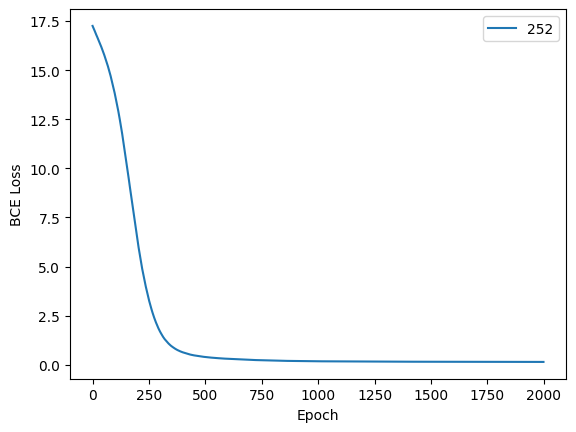

In [28]:
import matplotlib.pyplot as plt

plt.plot(loss_model, label="252")

plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.legend()
plt.show()

#### Recommendations with the trained Factorization Model

Let's write a function that recommends topK items to a user, whose id is given, using the trained model.
Our recommendation should be done in a fashion similar to *svd_recommend*: score items based the corresponding embeddings. We do not consider items already seen by the user.

In [29]:
def itMF_recommend(user_id: int, seen_item_ids: list, model=None, topK=10) -> np.ndarray:
    """
    Recommend with the trained model to selected users
    
    user_id - int - id of target user.
    seen_item_ids - list[list[int]] ids of items already seen by the users (to exclude from recommendation)
    model - trainted factorization model to use for scoring
    topK - number of recommendations per user to be returned
    
    returns - np.ndarray - np.ndarray - list of ids of recommended items in the order of descending score
                           use -1 as a place holder item index, when it is impossible to recommend topK items
    """
    recs = None

    model.eval()


    with torch.no_grad():

        state_dict = model.state_dict()
        U = state_dict['embedding_user.weight'].detach().numpy()
        V = state_dict['embedding_item.weight'].detach().numpy()

        rec = np.dot(U[user_id,:], V.T)
    
        for i in range(len(rec)):
            if i in seen_item_ids[0]:
                rec[i] = -1

        otv = np.argsort(rec)[::-1]
        otv = np.append(otv[:topK], [-1] * (topK - len(otv[:topK])))

    return np.array(otv)

# Part  : Evaluation

In [30]:
def get_ndcg_score(predictions: np.ndarray, test_interaction_matrix: np.ndarray, topK=10) -> float:
    """
    predictions - np.ndarray - predictions of the recommendation algorithm for each user.
    test_interaction_matrix - np.ndarray - test interaction matrix for each user.
    topK - int - topK recommendations should be evaluated.
    
    returns - average ndcg score over all users.
    """
    score = None
    
    # TODO: YOUR IMPLEMENTATION.
    ndcg_scores = []
    num_users = predictions.shape[0]

    for i in range(num_users):
        # Get the topK recommendations for the i-th user
        topk_items = predictions[i][:topK]
        
        # Get the held-out items for the i-th user
        held_out_items = np.where(test_interaction_matrix[i] == 1)[0]
        
        # Compute the ideal DCG for the i-th user
        ideal_dcg = 0.0
        for j in range(min(topK, len(held_out_items))):
            if j == 0:
                    ideal_dcg += 1.0
            else:
                ideal_dcg += 1.0 / np.log2(j + 2)
        
        # Compute the actual DCG for the i-th user
        dcg = 0.0
        for j, item in enumerate(topk_items):
            if item in held_out_items:
                if j == 0:
                    dcg += 1.0
                else:
                    dcg += 1.0 / np.log2(j + 2)

        # Compute the nDCG score for the i-th user
        if ideal_dcg > 0:
            ndcg = dcg / ideal_dcg
        else:
            ndcg = 0.0
        
        ndcg_scores.append(ndcg)

    # Compute the average nDCG score over all users
    score = np.mean(ndcg_scores)

    return score

In [31]:
config_predict = {
    #interaction matrix
    "train_inter": train_interaction_matrix,
    #topK parameter used for all algorithms
    "top_k": 10,
    #specific parameters for all algorithms
    "recommenders": {
        "SVD": {
            "n_factors": len(selected_elements)
        },
        "Iterative Matrix Factorization": {
            "n_factors": len(selected_elements)
        },
    }
}

In [32]:
def get_recommendations_for_algorithms(config: dict) -> dict:
    """
    config - dict - configuration as defined above

    returns - dict - already predefined below with name "rec_dict"
    """

    # get the top_k parameter from the config
    top_k = config["top_k"]
    
    #use this structure to return results
    rec_dict = {"recommenders": {
        "SVD": {
            #Add your predictions here
            "predictions": np.empty((0,top_k ))
        },
        # "Iterative Matrix Factorization": {
        #     "predictions": np.empty((0,top_k ))
        # },
    }}
    
    # get train_interaction_matrix from the config
    train_interaction_matrix = config["train_inter"]

    # get recommenders from the config
    recommenders = config['recommenders']
    
    #SVD
    n_factors = recommenders["SVD"]["n_factors"]
    U, V = u,v
        
    #Iterative Matrix Factorization
    # n_neighbours = recommenders["ItemKNN"]["n_neighbours"]
        
    for i in range(train_interaction_matrix.shape[0]):
        seen_list = np.where(train_interaction_matrix[i] != 0)
        rec_dict['recommenders']['SVD']['predictions'] = np.vstack([rec_dict['recommenders']['SVD']['predictions'],svd_recommend_to_list(i,seen_list,U,V,top_k)])
        #rec_dict['recommenders']['Iterative Matrix Factorization']['predictions'] = np.vstack([rec_dict['recommenders']['Iterative Matrix Factorization']['predictions'],recTopK(train_interaction_matrix,i,top_k,n_neighbours)])



    return rec_dict

In [33]:
recommendations = get_recommendations_for_algorithms(config_predict)

assert "SVD" in recommendations["recommenders"] and "predictions" in recommendations["recommenders"]["SVD"]
assert isinstance(recommendations["recommenders"]["SVD"]["predictions"], np.ndarray)
# assert "ItemKNN" in recommendations["recommenders"] and "predictions" in recommendations["recommenders"]["ItemKNN"]
# assert isinstance(recommendations["recommenders"]["ItemKNN"]["predictions"], np.ndarray)

In [34]:
config_test = {
    "top_k": 10,
    "test_inter": test_interaction_matrix,
    "recommenders": {}  # here you can access the recommendations from get_recommendations_for_algorithms

}
# add dictionary with recommendations to config dictionary
config_test.update(recommendations)

In [37]:
def evaluate_algorithms(config: dict) -> dict:
    """
    config - dict - configuration as defined above

    returns - dict - { Recommender Key from input dict: { "ndcg": float - ndcg from evaluation for this recommender} }
    """

    metrics = {
        "SVD": {
        },
        # "Iterative Matrix Factorization": {
        # },
    }

    # TODO: YOUR IMPLEMENTATION.
    
    top_k = config['top_k']
    test_interaction_matrix = config['test_inter']
    SVD = config['recommenders']['SVD']['predictions']
    #ItemKNN = config['recommenders']['Iterative Matrix Factorization']['predictions']


    metrics['SVD']['ndcg'] = get_ndcg_score(SVD, test_interaction_matrix, top_k)
    #metrics['Iterative Matrix Factorization']['ndcg'] = get_ndcg_score(ItemKNN,test_interaction_matrix, top_k)

    
    return metrics

In [38]:
evaluations = evaluate_algorithms(config_test)

for recommender in evaluations.keys():
    print(f"{recommender} ndcg: {evaluations[recommender]['ndcg']}")

SVD ndcg: 0.023616170887646743
